# Training of a self-organizing map (SOM)

In this tutorial we present the classification procedure of PINK.

We start by loading the python-pink module:

In [8]:
import pink

print(pink.__version__)

2.2 revision 0c7daed


As images we choose a set of clothing taken from [TensorFlow Keras](https://www.tensorflow.org/guide/keras).

In [9]:
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Show the first 25 images.

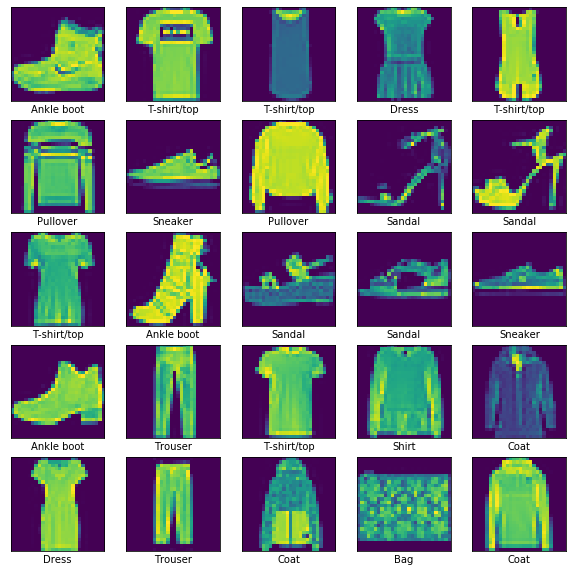

In [10]:
import matplotlib.pyplot as plt

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])

The SOM is defined as a 2-dimensional rectangular layout of the dimension 10x10 containing 2-dimensional rectangular neurons of the dimension 28x28. The datatype of the pixels will by `float32`. The SOM will be initialized with random numbers.

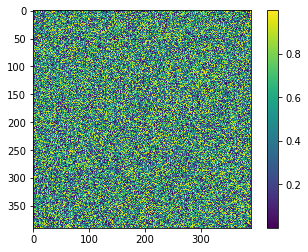

In [4]:
import math
import numpy as np

som_dim = 10
neuron_dim = int(train_images.shape[1] / math.sqrt(2.0) * 2.0)

np_som = np.random.rand(som_dim, som_dim, neuron_dim, neuron_dim).astype(np.float32)
som = pink.som(np_som)

plt.figure()
plt.imshow(np_som.swapaxes(1, 2).reshape((som_dim * neuron_dim, som_dim * neuron_dim)))
plt.colorbar()
plt.grid(False)

As distribution function for the training propagation we choose gaussian function:

\begin{equation*}
f = \frac{\omega}{\sigma \sqrt{2 \pi}} e^{-0.5 \left(\frac{d}{\sigma}\right)^{2}}
\end{equation*}

with $\omega$ as damping factor and $d$ as distance.

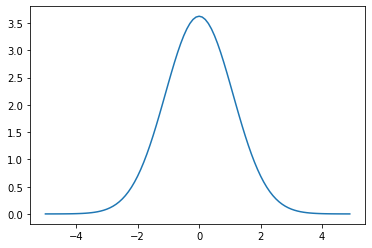

In [5]:
class GaussianFunctor():
    """ Returns the value of an gaussian distribution """

    def __init__(self, sigma=1.1, damping=0.2):
        self.sigma = sigma
        self.damping = damping

    def __call__(self, distance):
        return self.damping / (self.sigma * math.sqrt(2.0 * math.pi)) \
            * math.exp(-0.5 * math.pow((distance / self.sigma), 2))
    
x = np.arange(-5.0, 5.0, 0.1)
y = np.array([GaussianFunctor(1.1, 10.0)(i) for i in x])

plt.plot(x, y)

The trainer is defined with the distribution function and 180 rotated images. Below the SOM after the first updating iteration is shown.

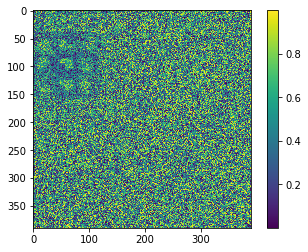

In [6]:
trainer = pink.trainer_gpu(som, distribution_function=GaussianFunctor(sigma=1.1, damping=1.0),
                           euclidean_distance_dim=int(train_images.shape[1] * math.sqrt(2.0) / 2.0),
                           number_of_rotations=180, use_flip=True)

np_image = train_images[0].astype(np.float32)
np_image /= 255
image = pink.data(np_image)

trainer(image)

trainer.update_som()
np_som = np.array(som, copy=True)

plt.figure()
plt.imshow(np_som.swapaxes(1, 2).reshape((som_dim * neuron_dim, som_dim * neuron_dim)))
plt.colorbar()
plt.grid(False)

After 1000 iterations the SOM looks sufficiently trained.

100%|██████████| 1000/1000 [00:00<00:00, 2692.77it/s]


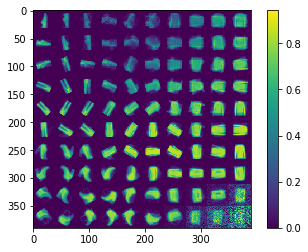

In [7]:
from tqdm import tqdm

for i in tqdm(range(1000)):

    np_image = train_images[i].astype(np.float32)
    np_image /= 255

    image = pink.data(np_image)
    trainer(image)

trainer.update_som()
np_som = np.array(som, copy=True)

plt.figure()
plt.imshow(np_som.swapaxes(1, 2).reshape((som_dim * neuron_dim, som_dim * neuron_dim)))
plt.colorbar()
plt.grid(False)